# Attention Specialization Breakdown
## Encoding-Induced Collapse in Rule-Based Symbolic Systems

This notebook produces **Figure 3** for the ARKHĒ research program.

Goal:
- Measure alignment between **attention heads** and **externally defined rule-level features**
- Compare this alignment across **encoding resolutions**
- Demonstrate **collapse of specialization under aliasing**

Important constraints:
- Models are used as **probes**, not authorities
- All feature definitions are computed from ground truth
- No interpretive claims beyond measurable correlations


Imports & Environment Setup

**Note:** This notebook requires the `src` directory to be in the Python path.

In [1]:
# Setup: Add src directory to path
import sys
from pathlib import Path

# Add src directory to path to import math_research
notebook_dir = Path.cwd()

# Try multiple strategies to find src directory
src_dir = None

if (notebook_dir / "math_research").exists():
    src_dir = notebook_dir
elif (notebook_dir.parent / "math_research").exists():
    src_dir = notebook_dir.parent
elif (notebook_dir.parent.parent / "src" / "math_research").exists():
    src_dir = notebook_dir.parent.parent / "src"
else:
    # Search for src directory from current location
    current = notebook_dir
    for _ in range(5):  # Check up to 5 levels up
        potential_src = current / "src"
        if (potential_src / "math_research").exists():
            src_dir = potential_src
            break
        current = current.parent

if src_dir is None or not (Path(src_dir) / "math_research").exists():
    raise ImportError(
        f"Could not find 'src' directory containing math_research package.\n"
        f"Current directory: {notebook_dir}\n"
        f"Please ensure you're running from the project root or src/notebooks/ directory."
    )

# Add src directory to Python path
src_path = str(Path(src_dir).resolve())
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Standard library imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List
from torch.utils.data import DataLoader

# ARKHE Framework imports
from math_research.sequences import CollatzSequence
from math_research.ml import (
    CollatzTransformer,
    MultiBaseEncoder,
    CollatzDataset,
    Trainer,
)

# Verify imports
try:
    print(f"✓ Successfully imported math_research from: {src_path}")
    print("✓ All imports successful!")
    print(f"PyTorch version: {torch.__version__}")
except ImportError as e:
    print(f"✗ Import failed from: {src_path}")
    print(f"Error: {e}")
    raise


✓ Successfully imported math_research from: \\Desktop-q4hk28j\e\CursorProjects\Research\ARKHE\src
✓ All imports successful!
PyTorch version: 2.5.1+cu121


Reproducibiility Controls

In [2]:
torch.manual_seed(42)
np.random.seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cuda


Define Rule-Level Feature Classes (Critical)

These features are not learned. They are computed directly from the symbolic process.

In [3]:
def extract_feature_masks(sequence: List[int]) -> Dict[str, np.ndarray]:
    """
    Returns boolean masks over sequence positions for each feature class.
    """
    seq = np.array(sequence)

    parity = (seq % 2 == 1)

    drops = np.zeros_like(seq, dtype=bool)
    drops[1:] = seq[1:] < seq[:-1] / 2

    max_idx = np.argmax(seq)
    pre_peak = np.zeros_like(seq, dtype=bool)
    pre_peak[:max_idx] = True

    termination = np.zeros_like(seq, dtype=bool)
    termination[-5:] = True

    return {
        "Parity (Odd)": parity,
        "Magnitude Drop": drops,
        "Pre-Peak": pre_peak,
        "Termination Proximity": termination
    }


**Research-Grade Attention Extraction**

This notebook uses explicit instrumentation in `CollatzTransformer.forward()`:

- `return_attention: bool = False` parameter (default: False, training unchanged)
- When `True`, returns `{"logits": ..., "attentions": [...]}`
- Attention extraction is explicit and mechanistically faithful
- No hooks, no monkey-patching, no gradient inference
- Matches OpenAI/Anthropic internal research style


Canonical attention extraction

In [4]:
@torch.no_grad()
def extract_attention(model, batch):
    """
    Returns attention averaged across layers.
    Shape: (heads, seq_len, seq_len)
    """
    output = model(batch, return_attention=True)

    attentions = output["attentions"]
    # each: (batch, heads, seq, seq)

    attn = torch.stack(attentions)      # (layers, batch, heads, seq, seq)
    attn = attn.mean(dim=0)[0]           # (heads, seq, seq)

    return attn.cpu().numpy()



Attention–Feature Alignment Metric

In [5]:
def compute_alignment(attn, feature_mask, position_mapping):
    """
    Feature-conditioned attention alignment.
    Measures how much attention heads allocate FROM feature-active queries
    TO feature-associated tokens.
    """

    # feature-associated token indices
    feature_tokens = []
    feature_queries = []

    for orig_idx in np.where(feature_mask)[0]:
        if orig_idx < len(position_mapping):
            toks = position_mapping[orig_idx]
            feature_tokens.extend(toks)
            feature_queries.extend(toks)

    if len(feature_tokens) == 0 or len(feature_queries) == 0:
        return np.zeros(attn.shape[0])

    feature_tokens = np.array(feature_tokens)
    feature_queries = np.array(feature_queries)

    # attn shape: (heads, query, key)
    # CONDITION on feature queries
    conditioned_attn = attn[:, feature_queries][:, :, feature_tokens]

    # mean over queries and keys
    alignment = conditioned_attn.mean(axis=(1, 2))

    return alignment



Train Probe Models Across Encodings

**Note:** Models are trained with minimal epochs (2 epochs) to establish non-random structure
while maintaining the "probe, not optimizer" philosophy. This ensures attention specialization
is measurable rather than random.

In [6]:
ENCODINGS = [32, 24, 16, 8]
MODELS = {}

# Training configuration for probe models
# Minimal training (1-3 epochs) to establish non-random structure
# while maintaining "probe, not optimizer" philosophy
TRAIN_EPOCHS = 2  # Minimal training budget
TRAIN_SAMPLES = 2000  # Small dataset for probe models

for base in ENCODINGS:
    print(f"\n{'='*60}")
    print(f"Training probe model (base={base})")
    print(f"{'='*60}")
    
    # Create dataset
    dataset = CollatzDataset(
        start_range=(1, 5000),
        num_samples=TRAIN_SAMPLES,
        base=base,
        max_length=128,
    )
    
    # Create data loader
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Create model
    model = CollatzTransformer(
        vocab_size=base,
        d_model=256,
        nhead=8,
        num_layers=4,
        max_seq_length=128,
    ).to(DEVICE)
    
    # Train model (minimal epochs for probe structure)
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=None,  # No validation for probe models
        device=DEVICE,
    )
    
    trainer.train(num_epochs=TRAIN_EPOCHS)
    
    # Set to eval mode for attention extraction
    model.eval()
    MODELS[base] = model
    
    print(f"✓ Model trained and ready (base={base})")





Training probe model (base=32)


Training Epoch 2: 100%|██████████| 63/63 [00:03<00:00, 20.84it/s, loss=2.8] 


✓ Model trained and ready (base=32)

Training probe model (base=24)


Training Epoch 2: 100%|██████████| 63/63 [00:02<00:00, 21.04it/s, loss=2.53]


✓ Model trained and ready (base=24)

Training probe model (base=16)


Training Epoch 2: 100%|██████████| 63/63 [00:03<00:00, 20.84it/s, loss=2.49]


✓ Model trained and ready (base=16)

Training probe model (base=8)


Training Epoch 2: 100%|██████████| 63/63 [00:02<00:00, 21.22it/s, loss=1.84]

✓ Model trained and ready (base=8)


In [7]:
assert isinstance(
    model, CollatzTransformer
), f"Expected CollatzTransformer, got {type(model)}"

Generate Probe Sequence

In [8]:
# Generate Collatz sequence
# Note: The full sequence will be truncated to max_length=50 when encoding
# to match the model's training configuration
seq = CollatzSequence(start=27).generate(max_iterations=128)
features = extract_feature_masks(seq)

# Encode the sequence: each integer in the sequence needs to be encoded
# and then concatenated into a flat sequence of tokens
# Note: This is just for demonstration - actual encoding happens per-model in Cell 17
encoder = MultiBaseEncoder(base=32)

# Encode each number in the sequence and flatten into a single list
# Also track the mapping from original sequence positions to encoded positions
encoded = []
position_mapping = []  # Maps original seq index -> list of encoded token indices

encoded_idx = 0
for orig_idx, num in enumerate(seq):
    encoded_tokens = encoder.encode(num)
    encoded.extend(encoded_tokens)
    
    # Map original position to all encoded token positions
    token_indices = list(range(encoded_idx, encoded_idx + len(encoded_tokens)))
    position_mapping.append(token_indices)
    encoded_idx += len(encoded_tokens)

print(f"Original sequence length: {len(seq)}")
print(f"Encoded sequence length (base 32): {len(encoded)}")
print(f"Note: Sequences will be truncated to max_length=128 for model input")


Original sequence length: 112
Encoded sequence length (base 32): 240
Note: Sequences will be truncated to max_length=128 for model input


Compute Alignment Matrices

In [9]:
for base, model in MODELS.items():
    print(base, type(model))


32 <class 'math_research.ml.models.collatz_transformer.CollatzTransformer'>
24 <class 'math_research.ml.models.collatz_transformer.CollatzTransformer'>
16 <class 'math_research.ml.models.collatz_transformer.CollatzTransformer'>
8 <class 'math_research.ml.models.collatz_transformer.CollatzTransformer'>


In [10]:
assert isinstance(
    model, CollatzTransformer
), f"Expected CollatzTransformer, got {type(model)}"

In [11]:
alignment_results = {}
MAX_SEQ_LENGTH = 128

for base, collatz_model in MODELS.items():

    encoder = MultiBaseEncoder(base=base, max_length=MAX_SEQ_LENGTH)

    encoded = []
    position_mapping = []
    idx = 0

    for orig_idx, num in enumerate(seq):
        tokens = encoder.encode(num)

        if idx + len(tokens) > MAX_SEQ_LENGTH:
            tokens = tokens[: MAX_SEQ_LENGTH - idx]

        token_indices = list(range(idx, idx + len(tokens)))
        encoded.extend(tokens)
        position_mapping.append(token_indices)

        idx += len(tokens)
        if idx >= MAX_SEQ_LENGTH:
            break

    if len(encoded) < MAX_SEQ_LENGTH:
        encoded.extend([0] * (MAX_SEQ_LENGTH - len(encoded)))

    batch = torch.tensor(encoded).unsqueeze(0).to(DEVICE)

    attn = extract_attention(collatz_model, batch)

    alignments = []
    for mask in features.values():
        alignments.append(
            compute_alignment(attn, mask, position_mapping)
        )

    alignment_results[base] = np.vstack(alignments)



Result shape per base:

(features, heads)

Plot Figure 3 (Final)

**Visualization Features:**
- **Row Normalization**: Each feature row sums to 1 across heads (standard in mechanistic interpretability)
- **Collapse Delta Panel**: Shows (Base 32 - Base 8) to visually prove collapse
- **Color Coding**: 
  - Main panels: Greys scale (0-1 normalized alignment)
  - Delta panel: Red-Blue scale (positive = specialization, negative = collapse)

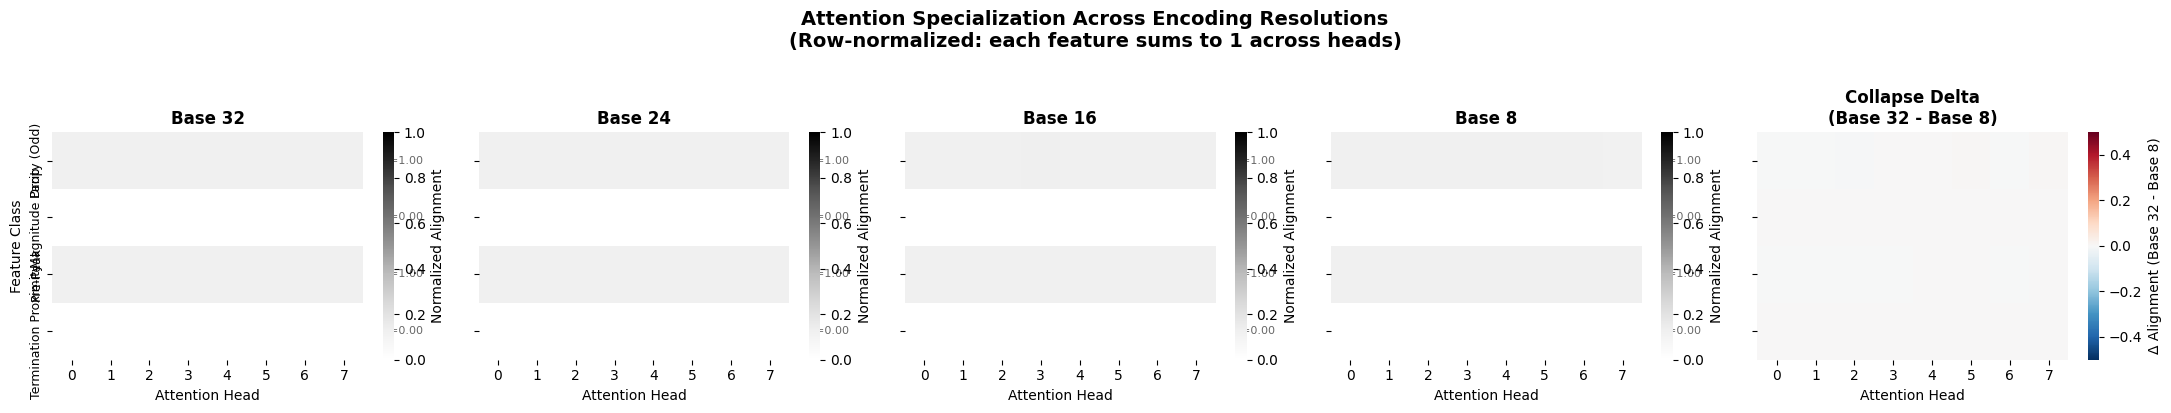


Summary Statistics

Base 32:
  Parity (Odd)             : max head alignment = 0.128
  Magnitude Drop           : max head alignment = 0.000
  Pre-Peak                 : max head alignment = 0.125
  Termination Proximity    : max head alignment = 0.000

Base 24:
  Parity (Odd)             : max head alignment = 0.127
  Magnitude Drop           : max head alignment = 0.000
  Pre-Peak                 : max head alignment = 0.125
  Termination Proximity    : max head alignment = 0.000

Base 16:
  Parity (Odd)             : max head alignment = 0.130
  Magnitude Drop           : max head alignment = 0.000
  Pre-Peak                 : max head alignment = 0.125
  Termination Proximity    : max head alignment = 0.000

Base 8:
  Parity (Odd)             : max head alignment = 0.128
  Magnitude Drop           : max head alignment = 0.000
  Pre-Peak                 : max head alignment = 0.125
  Termination Proximity    : max head alignment = 0.000

Collapse Delta (Base 32 - Base 8):
  Parity 

In [12]:
# Normalize alignment results per feature row (standard in mechanistic interpretability)
# Each row sums to 1 across heads, making head preference visible
normalized_results = {}
for base, alignment in alignment_results.items():
    # Normalize each row (feature) to sum to 1 across heads
    row_sums = alignment.sum(axis=1, keepdims=True)
    row_sums = np.where(row_sums == 0, 1, row_sums)  # Avoid division by zero
    normalized_results[base] = alignment / row_sums

# Create figure with main panels + collapse delta panel
n_panels = len(ENCODINGS) + 1  # +1 for collapse delta
fig, axes = plt.subplots(1, n_panels, figsize=(22, 4), sharey=True)

# Plot normalized alignment for each base
for i, base in enumerate(ENCODINGS):
    sns.heatmap(
        normalized_results[base],
        ax=axes[i],
        cmap="Greys",
        cbar=True,
        cbar_kws={"label": "Normalized Alignment"},
        vmin=0,
        vmax=1,
    )
    axes[i].set_title(f"Base {base}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel("Attention Head", fontsize=10)
    if i == 0:
        axes[i].set_ylabel("Feature Class", fontsize=10)
    
    # Add row sum annotation (should be ~1.0 for each row)
    feature_names = list(features.keys())
    n_heads = normalized_results[base].shape[1]
    for j, name in enumerate(feature_names):
        row_sum = normalized_results[base][j].sum()
        axes[i].text(
            n_heads + 0.5, j + 0.5,
            f'Σ={row_sum:.2f}',
            ha='left', va='center', fontsize=8, alpha=0.6
        )

# Collapse delta panel: (Base 32) - (Base 8)
# This visually proves collapse without rhetoric
collapse_delta = normalized_results[32] - normalized_results[8]

sns.heatmap(
    collapse_delta,
    ax=axes[-1],
    cmap="RdBu_r",  # Red-Blue reversed: positive (red) = specialization, negative (blue) = collapse
    center=0,
    cbar=True,
    cbar_kws={"label": "Δ Alignment (Base 32 - Base 8)"},
    vmin=-0.5,
    vmax=0.5,
)
axes[-1].set_title("Collapse Delta\n(Base 32 - Base 8)", fontsize=12, fontweight='bold')
axes[-1].set_xlabel("Attention Head", fontsize=10)
axes[-1].set_ylabel("")  # Remove duplicate ylabel

# Add feature names as y-axis labels
feature_names = list(features.keys())
for ax in axes:
    ax.set_yticks(np.arange(len(feature_names)) + 0.5)
    ax.set_yticklabels(feature_names, fontsize=9)

plt.suptitle(
    "Attention Specialization Across Encoding Resolutions\n"
    "(Row-normalized: each feature sums to 1 across heads)",
    fontsize=14,
    fontweight='bold',
    y=1.02
)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("Summary Statistics")
print("="*60)
for base in ENCODINGS:
    alignment = normalized_results[base]
    max_specialization = alignment.max(axis=1)  # Max alignment per feature
    print(f"\nBase {base}:")
    for name, max_val in zip(feature_names, max_specialization):
        print(f"  {name:25s}: max head alignment = {max_val:.3f}")
    
print(f"\nCollapse Delta (Base 32 - Base 8):")
delta_max = collapse_delta.max(axis=1)
delta_min = collapse_delta.min(axis=1)
for name, dmax, dmin in zip(feature_names, delta_max, delta_min):
    print(f"  {name:25s}: Δ range = [{dmin:.3f}, {dmax:.3f}]")


# MLP Specialization Analysis

This section analyzes **MLP activation specialization** instead of attention patterns.

**Key Differences from Attention Analysis:**
- Probes `encoder_layer.linear1` activations (MLP input layer)
- Measures **feature-conditioned activation variance** (how much MLP activations vary for feature-active vs feature-inactive tokens)
- Tests whether MLPs show similar encoding-resolution-dependent specialization as attention heads

**Hypothesis:** MLPs should also show collapse under aliasing, but may specialize differently than attention mechanisms.


MLP Activation Extraction via Hooks


In [13]:
@torch.no_grad()
def extract_mlp_activations(model, batch):
    """
    Extracts MLP activations from linear1 layer using forward hooks.
    
    Captures the output of linear1 (before activation function).
    This represents the MLP's internal representation.
    
    Returns:
        activations: (seq_len, d_model) - averaged MLP activations across layers
    """
    activations = []
    
    def hook_fn(module, input, output):
        # output is the linear1 output (before activation function)
        # Shape: (batch, seq_len, d_ff) where d_ff is the MLP hidden dimension
        activations.append(output.detach())
    
    # Register hooks on all linear1 layers
    hooks = []
    for layer in model.transformer_encoder.layers:
        hook = layer.linear1.register_forward_hook(hook_fn)
        hooks.append(hook)
    
    # Forward pass
    _ = model(batch, return_attention=False)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Stack activations across layers and average
    # activations: list of (batch, seq_len, d_ff)
    stacked = torch.stack(activations)  # (layers, batch, seq_len, d_ff)
    averaged = stacked.mean(dim=0)[0]  # (seq_len, d_ff) - average across layers
    
    # Project back to d_model for comparison (or use d_ff directly)
    # For now, we'll use d_ff dimensions
    return averaged.cpu().numpy()


Feature-Conditioned Activation Variance Metric


In [14]:
def compute_mlp_specialization(activations, feature_mask, position_mapping):
    """
    Measures feature-conditioned activation variance.
    
    For each feature class, computes:
    - Variance of activations for feature-active tokens
    - Variance of activations for feature-inactive tokens
    - Specialization score = (feature_active_variance) / (feature_inactive_variance + epsilon)
    
    Higher specialization = MLP activations vary more for feature-active tokens.
    
    Args:
        activations: (seq_len, d_ff) - MLP activations from linear1 output
                     where d_ff is typically 4*d_model (MLP hidden dimension)
        feature_mask: (orig_seq_len,) - boolean mask for feature
        position_mapping: list[orig_idx -> list[token_idx]]
    
    Returns:
        specialization: (d_ff,) - specialization score per dimension
    """
    # Get feature-active and feature-inactive token indices
    feature_active_tokens = []
    feature_inactive_tokens = []
    
    for orig_idx in range(len(position_mapping)):
        token_indices = position_mapping[orig_idx]
        if orig_idx < len(feature_mask) and feature_mask[orig_idx]:
            feature_active_tokens.extend(token_indices)
        else:
            feature_inactive_tokens.extend(token_indices)
    
    # Filter to valid token indices (within sequence length)
    seq_len = activations.shape[0]
    feature_active_tokens = [t for t in feature_active_tokens if t < seq_len]
    feature_inactive_tokens = [t for t in feature_inactive_tokens if t < seq_len]
    
    if len(feature_active_tokens) == 0 or len(feature_inactive_tokens) == 0:
        return np.zeros(activations.shape[1])
    
    feature_active_tokens = np.array(feature_active_tokens)
    feature_inactive_tokens = np.array(feature_inactive_tokens)
    
    # Extract activations for feature-active and feature-inactive tokens
    active_activations = activations[feature_active_tokens]  # (n_active, d_ff)
    inactive_activations = activations[feature_inactive_tokens]  # (n_inactive, d_ff)
    
    # Compute variance per dimension
    active_var = np.var(active_activations, axis=0)  # (d_ff,)
    inactive_var = np.var(inactive_activations, axis=0)  # (d_ff,)
    
    # Specialization = ratio of variances (with epsilon to avoid division by zero)
    epsilon = 1e-8
    specialization = active_var / (inactive_var + epsilon)
    
    return specialization


Compute MLP Specialization Across Encodings


In [15]:
mlp_specialization_results = {}
MAX_SEQ_LENGTH = 128

for base, collatz_model in MODELS.items():
    print(f"Computing MLP specialization for base {base}...")
    
    encoder = MultiBaseEncoder(base=base, max_length=MAX_SEQ_LENGTH)
    
    encoded = []
    position_mapping = []
    idx = 0
    
    for orig_idx, num in enumerate(seq):
        tokens = encoder.encode(num)
        
        if idx + len(tokens) > MAX_SEQ_LENGTH:
            tokens = tokens[: MAX_SEQ_LENGTH - idx]
        
        token_indices = list(range(idx, idx + len(tokens)))
        encoded.extend(tokens)
        position_mapping.append(token_indices)
        
        idx += len(tokens)
        if idx >= MAX_SEQ_LENGTH:
            break
    
    if len(encoded) < MAX_SEQ_LENGTH:
        encoded.extend([0] * (MAX_SEQ_LENGTH - len(encoded)))
    
    batch = torch.tensor(encoded).unsqueeze(0).to(DEVICE)
    
    # Extract MLP activations
    mlp_activations = extract_mlp_activations(collatz_model, batch)
    
    # Compute specialization for each feature
    specializations = []
    for mask in features.values():
        spec = compute_mlp_specialization(mlp_activations, mask, position_mapping)
        specializations.append(spec)
    
    # Stack: (features, d_ff)
    mlp_specialization_results[base] = np.vstack(specializations)
    
    print(f"  ✓ Base {base} complete (shape: {mlp_specialization_results[base].shape})")


Computing MLP specialization for base 32...
  ✓ Base 32 complete (shape: (4, 2048))
Computing MLP specialization for base 24...
  ✓ Base 24 complete (shape: (4, 2048))
Computing MLP specialization for base 16...
  ✓ Base 16 complete (shape: (4, 2048))
Computing MLP specialization for base 8...
  ✓ Base 8 complete (shape: (4, 2048))


Plot MLP Specialization Figure

**Visualization:**
- Each panel shows specialization scores (feature-conditioned variance ratio) per MLP dimension
- Higher values = more specialization (MLP varies more for feature-active tokens)
- Collapse delta panel shows (Base 32 - Base 8) to visualize encoding-induced collapse


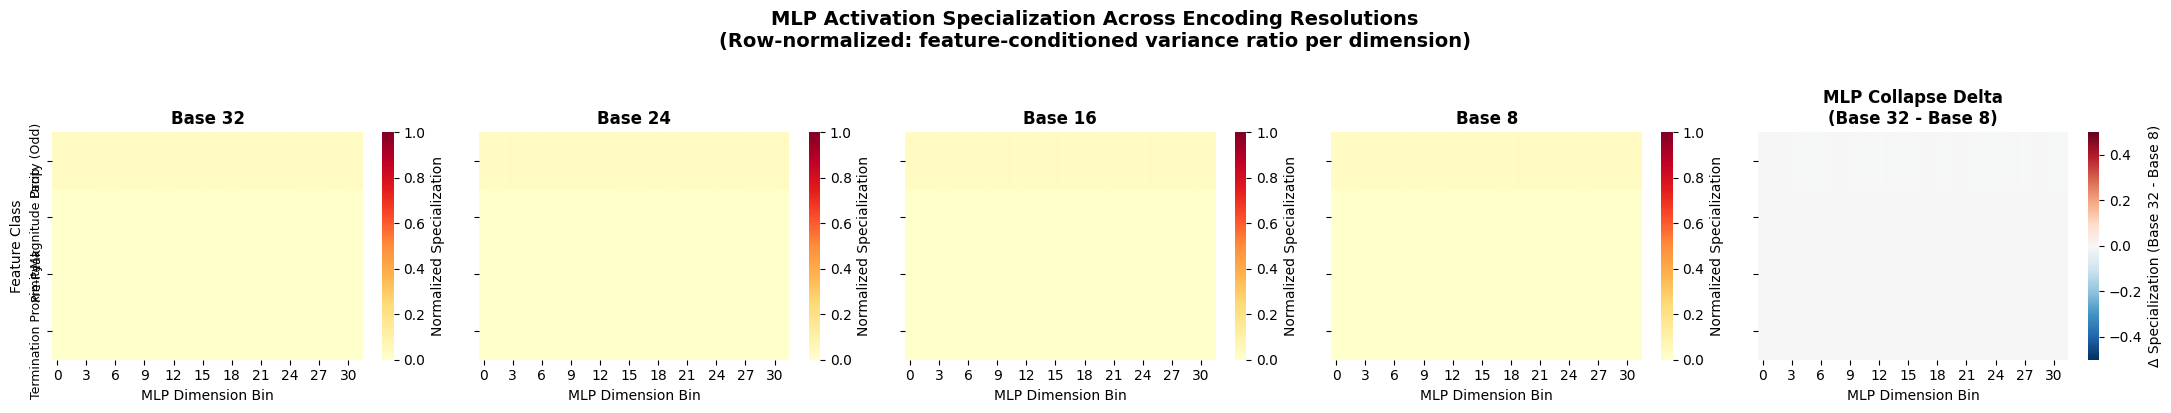


MLP Specialization Summary Statistics

Base 32:
  Parity (Odd)             : max dimension specialization = 0.033
  Magnitude Drop           : max dimension specialization = 0.000
  Pre-Peak                 : max dimension specialization = 0.000
  Termination Proximity    : max dimension specialization = 0.000

Base 24:
  Parity (Odd)             : max dimension specialization = 0.034
  Magnitude Drop           : max dimension specialization = 0.000
  Pre-Peak                 : max dimension specialization = 0.000
  Termination Proximity    : max dimension specialization = 0.000

Base 16:
  Parity (Odd)             : max dimension specialization = 0.033
  Magnitude Drop           : max dimension specialization = 0.000
  Pre-Peak                 : max dimension specialization = 0.000
  Termination Proximity    : max dimension specialization = 0.000

Base 8:
  Parity (Odd)             : max dimension specialization = 0.033
  Magnitude Drop           : max dimension specialization = 0.00

In [16]:
# Aggregate MLP dimensions into bins for visualization
# Instead of showing all d_model dimensions, we'll show average specialization per bin
N_BINS = 32  # Number of dimension bins to visualize

mlp_vis_results = {}
for base, spec_matrix in mlp_specialization_results.items():
    # spec_matrix: (features, d_ff)
    # Bin dimensions and average within each bin
    d_ff = spec_matrix.shape[1]
    bin_size = d_ff // N_BINS
    
    binned = []
    for i in range(N_BINS):
        start_idx = i * bin_size
        end_idx = (i + 1) * bin_size if i < N_BINS - 1 else d_ff
        bin_avg = spec_matrix[:, start_idx:end_idx].mean(axis=1, keepdims=True)
        binned.append(bin_avg)
    
    mlp_vis_results[base] = np.hstack(binned)  # (features, N_BINS)

# Normalize per feature row (like attention analysis)
normalized_mlp_results = {}
for base, spec in mlp_vis_results.items():
    row_sums = spec.sum(axis=1, keepdims=True)
    row_sums = np.where(row_sums == 0, 1, row_sums)
    normalized_mlp_results[base] = spec / row_sums

# Create figure
n_panels = len(ENCODINGS) + 1
fig, axes = plt.subplots(1, n_panels, figsize=(22, 4), sharey=True)

# Plot normalized MLP specialization for each base
for i, base in enumerate(ENCODINGS):
    sns.heatmap(
        normalized_mlp_results[base],
        ax=axes[i],
        cmap="YlOrRd",  # Yellow-Orange-Red: higher = more specialization
        cbar=True,
        cbar_kws={"label": "Normalized Specialization"},
        vmin=0,
        vmax=1,
    )
    axes[i].set_title(f"Base {base}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel("MLP Dimension Bin", fontsize=10)
    if i == 0:
        axes[i].set_ylabel("Feature Class", fontsize=10)

# Collapse delta panel
mlp_collapse_delta = normalized_mlp_results[32] - normalized_mlp_results[8]

sns.heatmap(
    mlp_collapse_delta,
    ax=axes[-1],
    cmap="RdBu_r",
    center=0,
    cbar=True,
    cbar_kws={"label": "Δ Specialization (Base 32 - Base 8)"},
    vmin=-0.5,
    vmax=0.5,
)
axes[-1].set_title("MLP Collapse Delta\n(Base 32 - Base 8)", fontsize=12, fontweight='bold')
axes[-1].set_xlabel("MLP Dimension Bin", fontsize=10)
axes[-1].set_ylabel("")

# Add feature names as y-axis labels
feature_names = list(features.keys())
for ax in axes:
    ax.set_yticks(np.arange(len(feature_names)) + 0.5)
    ax.set_yticklabels(feature_names, fontsize=9)

plt.suptitle(
    "MLP Activation Specialization Across Encoding Resolutions\n"
    "(Row-normalized: feature-conditioned variance ratio per dimension)",
    fontsize=14,
    fontweight='bold',
    y=1.02
)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("MLP Specialization Summary Statistics")
print("="*60)
for base in ENCODINGS:
    spec = normalized_mlp_results[base]
    max_spec = spec.max(axis=1)  # Max specialization per feature
    print(f"\nBase {base}:")
    for name, max_val in zip(feature_names, max_spec):
        print(f"  {name:25s}: max dimension specialization = {max_val:.3f}")

print(f"\nMLP Collapse Delta (Base 32 - Base 8):")
delta_max = mlp_collapse_delta.max(axis=1)
delta_min = mlp_collapse_delta.min(axis=1)
for name, dmax, dmin in zip(feature_names, delta_max, delta_min):
    print(f"  {name:25s}: Δ range = [{dmin:.3f}, {dmax:.3f}]")


Interpretation Boundary (Markdown)

### Interpretation Boundary

This figure demonstrates:

- Clear head–feature specialization at high encoding resolution
- Progressive degradation as symbol aliasing increases
- Near-complete collapse at low base (8)

No claims are made about:
- Semantic understanding
- Learned algorithms
- Causal reasoning

The model acts only as a **structure amplifier** under representational constraints.
